In [1]:
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
import h5py
import timeit
import time
import numpy as np
from scipy import stats
import pickle as pkl
from os import listdir
from os.path import isfile, join



/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
run_in_jupyter = False
try:
    cfg = get_ipython().config 
    run_in_jupyter = True
except:
    run_in_jupyter = False
    pass

if run_in_jupyter:
    import matplotlib.pyplot as plt
    %matplotlib inline
else: 
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    
print("Run in Jupyter = " + str(run_in_jupyter))

Run in Jupyter = True


In [3]:
import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import h5py
import matplotlib as mpl
from pathlib import Path

In [4]:
root_dir = "./"  # this goes to 
data_dir = "../"
if run_in_jupyter:
    experiment = root_dir + "drive_output/"       # : output directory of saved models
else:
    experiment = root_dir + "mmd-jupyter/"
model_save_folder = experiment + "model/"
redshift_fig_folder = experiment + "figures/"        # folder to save mmd & related plots
redshift_3dfig_folder = experiment + "/3d_figures/"   # folder to save 3D plots
testing_folder = experiment + "testing/"   # folder to save 3D plots

save_model_every = 10               # (every x epoch) frequency to save the model


In [5]:
workers = 2          # WORKERS: number of threads to load data
redshift_info_folder = experiment + "redshift_info/"   # save some info here as pickle to speed up processing
redshift_raw_file = "fields_z=0.0.hdf5"
redshift_file = "minmax_scale_01_redshift0.h5"    # redshift cube to be used
    # standardized_no_shift_redshift0.h5
    # minmax_scale_01_redshift0.h5
    # minmax_scale_neg11_redshift0.h5
inverse_transform = "minmax01"    # minmax11 / minmaxneg11 / std_noshift / std

In [6]:
if run_in_jupyter:
    %run utils/data_utils.py
else:
    from utils.data_utils import *
    
if run_in_jupyter:
    %run utils/plot_utils.py
else:
    from utils.plot_utils import *
    
if run_in_jupyter:
    %run dataset.py
else:
    from dataset import *

In [7]:
min_cube,max_cube,mean_cube,stddev_cube = get_stats_cube(redshift_info_folder = redshift_info_folder,
                                           redshift_file = redshift_file,
                                           data_dir = data_dir)
min_raw_cube,max_raw_cube,mean_raw_cube,stddev_raw_cube = get_stats_cube(redshift_info_folder = redshift_info_folder,
                                           redshift_file = redshift_raw_file,
                                           data_dir = data_dir)
print("\nTransformed Data Summary Statistics:")
print("File = " + str(redshift_file))
print("Min of data = " + str(min_cube))
print("Max of data = " + str(max_cube))
print("Mean of data = " + str(mean_cube))
print("Stddev of data = " + str(stddev_cube))

print("\nRaw Data Summary Statistics:")
print("File = " + str(redshift_raw_file))
print("Min of raw data = " + str(min_raw_cube))
print("Max of raw data = " + str(max_raw_cube))
print("Mean of raw data = " + str(mean_raw_cube))
print("Stddev of raw data = " + str(stddev_raw_cube))


Transformed Data Summary Statistics:
File = minmax_scale_01_redshift0.h5
Min of data = 0.0
Max of data = 1.0
Mean of data = 5.602617344322861e-07
Stddev of data = 0.0001913798544188446

Raw Data Summary Statistics:
File = fields_z=0.0.hdf5
Min of raw data = 0.0
Max of raw data = 18153447000.0
Mean of raw data = 10170.682
Stddev of raw data = 3474200.8


In [8]:
cube_size = 128
edge_sample = cube_size
edge_test = 1024
n_samples = 128
batch_size = 16

In [9]:
f = h5py.File(data_dir + redshift_file, 'r')
print("File used for analysis = " + str(f.filename))
f = f['delta_HI']

File used for analysis = ../minmax_scale_01_redshift0.h5


In [10]:
f_raw = h5py.File(data_dir + redshift_raw_file, 'r')
print("File used for analysis = " + str(f_raw.filename))
f_raw = f_raw['delta_HI']

File used for analysis = ../fields_z=0.0.hdf5


In [11]:
raw_cube = f_raw[128:256,128:256,128:256]
sampled_cube = f[128:256,128:256,128:256]

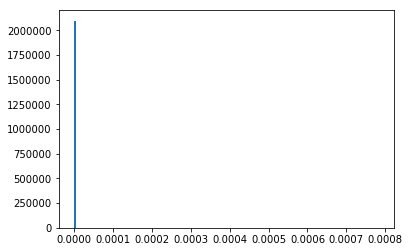

In [12]:
_ = plt.hist(sampled_cube.reshape(-1),
             log = False,
             bins = 200)

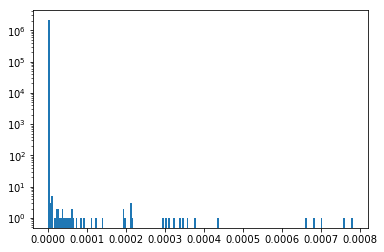

In [13]:
_ = plt.hist(sampled_cube.reshape(-1),
             log = True,
             bins = 200)

In [14]:
# on prince
sampled_subcubes = HydrogenDataset(h5_file=redshift_file,
                                    root_dir = data_dir,
                                    f = h5py.File(data_dir + redshift_file, 'r')["delta_HI"],
                                    s_test = edge_test, 
                                    s_train = edge_sample,
                                    s_sample = edge_sample, 
                                    nsamples = n_samples,
                                   min_cube = min_cube,
                                  max_cube = max_cube,
                                  mean_cube = mean_cube,
                                  stddev_cube = stddev_cube,
                                   min_raw_cube = min_raw_cube,
                                  max_raw_cube = max_raw_cube,
                                  mean_raw_cube = mean_raw_cube,
                                  stddev_raw_cube = stddev_raw_cube)

In [15]:
sampled_cube_inv = inverse_transform_func(cube = sampled_cube,
                                          inverse_type = inverse_transform, 
                                          sampled_dataset = sampled_subcubes)

In [16]:
print("mean:" + str(np.mean(raw_cube)))
print("mean:" + str(np.mean(sampled_cube_inv)))
print("std:" + str(np.std(raw_cube)))
print("std:" + str(np.std(sampled_cube_inv)))
print("max:" + str(np.amax(raw_cube)))
print("max:" + str(np.amax(sampled_cube_inv)))
print("min:" + str(np.amin(raw_cube)))
print("min:" + str(np.amin(sampled_cube_inv)))

mean:82.518555
mean:82.51859320875046
std:25239.871
std:25239.88815557503
max:14201433.0
max:14201432.766242504
min:0.0
min:0.0


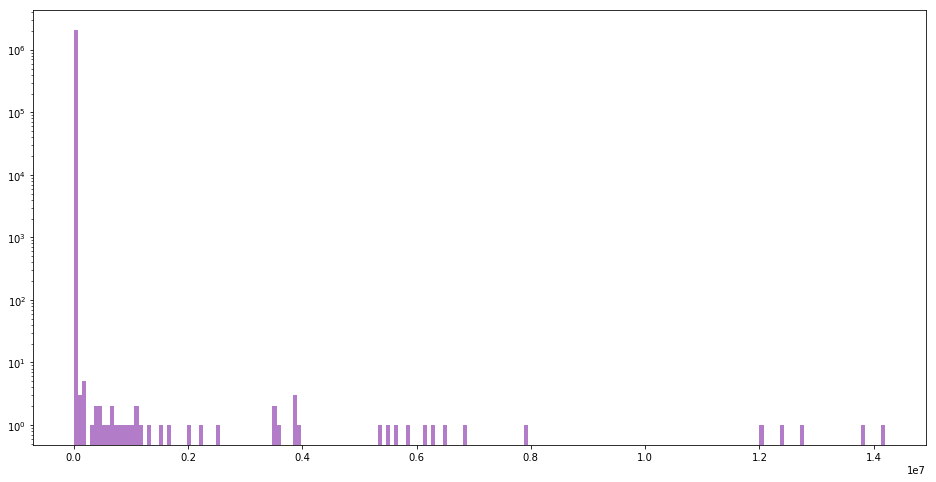

In [17]:
plt.figure(figsize = (16,8))
plt.hist(raw_cube.reshape(-1),
             log = True,
         color = "red",
         alpha = 0.3,
             bins = 200)
plt.hist(sampled_cube_inv.reshape(-1),
             log = True,
                  color = "blue",
         alpha = 0.3,
             bins = 200)
plt.show()
plt.close()